# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Признаки:

- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Целевой признак:

- Price — цена (евро)

## Подготовка данных

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import roc_auc_score
import seaborn as sns                                      
import matplotlib.pyplot as plt

from sklearn.preprocessing import OrdinalEncoder
from sklearn import preprocessing
from catboost import Pool

Откроем и посмотрим файл:

In [2]:
data = pd.read_csv('/datasets/autos.csv')
display(data.head(10))
data.info()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


Наша таблица размером 354369 строк и 16 столбцов. Есть столбцы с категориальными признаками.

Обнаружили, что:
- в столбцах есть пропуски,
- столбцы с датами не имеют формат даты.

Присутствуют столбцы, которые не повлияют на поставленную задачу:
- дата последней активности пользователя / LastSeen, 
- почтовый индекс владельца анкеты (пользователя) / PostalCode, 
- количество фотографий автомобиля / NumberOfPictures, 
- дата создания анкеты / DateCreated, 
- дата скачивания анкеты из базы / DateCrawled,
- месяц регистрации автомобиля / RegistrationMonth.

Удалим столбцы, которые ни как не повлияют на модель для определения цены:

In [3]:
data.drop(["LastSeen", "NumberOfPictures", "DateCreated", "DateCrawled",
           "RegistrationMonth", "PostalCode"], axis=1, inplace=True)

Проверим правильность наименования столбцов 

In [4]:
print("Наименование столбцов:", data.columns)                            

Наименование столбцов: Index(['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'FuelType', 'Brand', 'NotRepaired'],
      dtype='object')


Наименование столбцов правильное.

In [5]:
data.describe()

,Price,RegistrationYear,Power,Kilometer
count,354369.000000,354369.000000,354369.000000,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535
std,4514.158514,90.227958,189.850405,37905.341530
min,0.000000,1000.000000,0.000000,5000.000000
25%,1050.000000,1999.000000,69.000000,125000.000000
50%,2700.000000,2003.000000,105.000000,150000.000000
75%,6400.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


Видим максимальную цену 20000, год регистрации 1000 / 9999, а также мощность в 20000 лошадиных сил.
Надо провести исследование этих данных.

Процентное соотношение пропущенных значений:

In [6]:
pd.DataFrame(data.isna().mean().round(4)*100).sort_values(by=0)[::-1].style.background_gradient('coolwarm') 

,0
NotRepaired,20.08
VehicleType,10.58
FuelType,9.28
Gearbox,5.6
Model,5.56
Brand,0
Kilometer,0
Power,0
RegistrationYear,0
Price,0


Строки с пропущенными значениями в столбце Model (модель бренда), Gearbox (тип коробки передач) удалим, так как взять эти значения нам негде, а для модели они важны.

Пропущенных значений в NotRepaired очень много - 20,87 %, удалить их будет означать сократить таблицу на это значение, а это очень много.
При не заполненном поле NotRepaired будем считать, что машина в ремонте не была.

In [7]:
data["NotRepaired"].fillna("yes", inplace=True) 

Пропущенные значения в VehicleType, FuelType, Model и Gearbox удалим, так как взать их негде.

In [8]:
data.dropna(inplace=True)

Посмотрим что получилось после:

In [9]:
pd.DataFrame(data.isna().mean().round(4)*100).sort_values(by=0)[::-1].style.background_gradient('coolwarm') 

,0
NotRepaired,0
Brand,0
FuelType,0
Kilometer,0
Model,0
Power,0
Gearbox,0
RegistrationYear,0
VehicleType,0
Price,0


Посмотрим есть ли дубликаты:    

In [10]:
data.duplicated().sum()                                    

41260

Удалим дубликаты:

In [11]:
data = data.drop_duplicates().reset_index(drop=True)  

Посмотрим оставшеюся таблицу

In [12]:
display(data.head())                               

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,yes
1,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
2,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
3,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
4,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no


Посмотрим числовые столбцы:

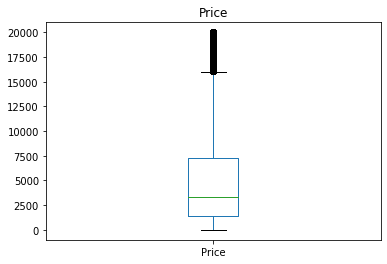

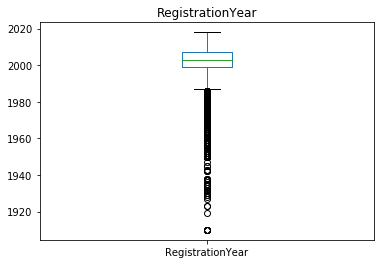

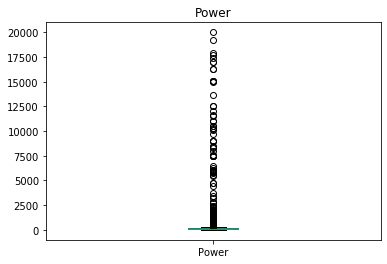

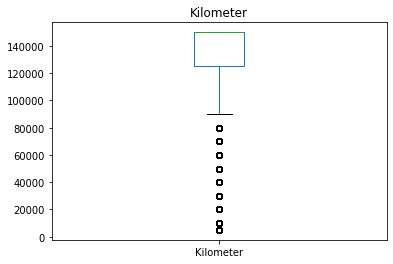

In [13]:
numerical = data.select_dtypes(include='number')         

for columns in numerical:
    data[columns].plot.box()
    plt.title(columns)
    plt.show()

Видим большие выбросы во всех столбцах. Столбец "Kilometer" не будем трогать, так так пробег может быть любой. Остальные столбцы ограничим.

In [14]:
data = data.query('RegistrationYear <= 2016 and RegistrationYear >= 1945 and Power >= 30 and Power <= 1200 and Price <= 20000')

Посмотрим итоговый размер выборки:

In [15]:
data.shape                                   

(227592, 10)

Переделаем категориальные значения в числовые применив технику прямого кодирования.

In [16]:
data_ohe = pd.get_dummies(data, drop_first=True)

Эти данные будем использовать для линейной регресси и LightGBM.

Скопируем наш файл для работы с OrdinalEncoder и categorical_features

In [17]:
data_categorical_features = data.copy(deep=True)

In [18]:
enc = OrdinalEncoder()
data.loc[:, ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand',
             'NotRepaired']] = enc.fit_transform(data[['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']])

Посмотрим, что получилось

In [19]:
display(data.head())                

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,9800,6.0,2004,0.0,163,117.0,125000,2.0,14.0,1.0
1,1500,5.0,2001,1.0,75,116.0,150000,6.0,37.0,0.0
2,3600,5.0,2008,1.0,69,101.0,90000,2.0,31.0,0.0
3,650,4.0,1995,1.0,102,11.0,150000,6.0,2.0,1.0
4,2200,1.0,2004,1.0,109,8.0,150000,6.0,25.0,0.0


In [20]:
print(data.shape)

(227592, 10)


Подготовим категориальные признаки для CatBoostRegressor

In [21]:
categorical_features = data_categorical_features[['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']]

### Вывод

Открыли и прочитали исходный файл, его размеры 354369 строк и 16 столбцов. 

Подготовили файл для дальнейшей работы:
- удалили ненужные столбцы для обучения.
- обработали пропущенные значения.
- удалили дубликаты
- в столбцах "год регистрации", "цена" и "мощность" убрали выбросы
- обработали категориальные значения методом прямого кодирования и OrdinalEncoder
- подготовили категориальные признаки для CatBoostRegressor.

## Обучение моделей

### Целевые признаки для метода OHE

In [22]:
features_ohe = data_ohe.drop(['Price'], axis = 1)
target_ohe = data_ohe['Price']

In [23]:
features_train_ohe, features_test_ohe, target_train_ohe, target_test_ohe = train_test_split(features_ohe, 
                                                                                target_ohe, test_size=0.25, random_state=12345) 

In [24]:
print(features_ohe.shape, target_ohe.shape)

(227592, 304) (227592,)


### Целевые признаки для метода OrdinalEncoder

In [25]:
features = data.drop(['Price'], axis = 1)
target = data['Price']

In [26]:
features_train, features_test, target_train, target_test = train_test_split(features, target,
                                                                            test_size=0.25, random_state=12345)

In [27]:
print(features.shape, target.shape)

(227592, 9) (227592,)


### Целевые признаки для метода указания категориальных значений

In [28]:
features_cf = data_categorical_features.drop(['Price'], axis = 1)
target_cf = data_categorical_features['Price']

In [29]:
features_train_cf, features_test_cf, target_train_cf, target_test_cf = train_test_split(features_cf,
                                                                                target_cf, test_size=0.25, random_state=12345)

In [30]:
print(features_cf.shape, target_cf.shape)

(227592, 9) (227592,)


### Формула для расчета RSME

In [31]:
def rmse (target, predictions):
    mse = mean_squared_error(target, predictions)
    rmse = mse ** 0.5
    return rmse

### Линейная регрессия

#### Применяя OHE

In [32]:
lr_model = LinearRegression()

In [33]:
%%time
lr_model.fit(features_ohe, target_ohe)

CPU times: user 18.8 s, sys: 6.34 s, total: 25.1 s
Wall time: 25.3 s


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [34]:
%%time
predicted_lr = pd.Series(lr_model.predict(features_ohe))

CPU times: user 321 ms, sys: 342 ms, total: 663 ms
Wall time: 681 ms


In [35]:
print("RMSE линейной регрессии: {:.2f}".format(rmse(target_ohe, predicted_lr)))

RMSE линейной регрессии: 2637.22


#### Применяя OrdinalEncoder

In [36]:
%%time
lr_model.fit(features, target)

CPU times: user 87.6 ms, sys: 20.8 ms, total: 108 ms
Wall time: 126 ms


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [37]:
%%time
predicted_lr = pd.Series(lr_model.predict(features))

CPU times: user 31.9 ms, sys: 59.9 ms, total: 91.8 ms
Wall time: 62.5 ms


In [38]:
print("RMSE линейной регрессии: {:.2f}".format(rmse(target, predicted_lr)))

RMSE линейной регрессии: 3030.01


### LightGBM

#### Применяя OHE

Возьмем две модели с разными параметрами и из них выберем лучшую.

In [39]:
lightgbm_model_1 = LGBMRegressor(depth = 15, n_estimators = 100, learning_rate = 0.1, random_state = 12345)

In [40]:
lightgbm_model_2 = LGBMRegressor(depth = 7, n_estimators = 150, learning_rate = 0.1, random_state = 12345)

In [41]:
%%time
lightgbm_model_1.fit(features_ohe, target_ohe)

CPU times: user 1min 35s, sys: 742 ms, total: 1min 36s
Wall time: 1min 36s


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              depth=15, importance_type='split', learning_rate=0.1,
              max_depth=-1, min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
              objective=None, random_state=12345, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

In [42]:
%%time
lightgbm_model_2.fit(features_ohe, target_ohe)

CPU times: user 2min 32s, sys: 1.22 s, total: 2min 33s
Wall time: 2min 35s


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              depth=7, importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=150, n_jobs=-1, num_leaves=31, objective=None,
              random_state=12345, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [43]:
%%time
predictions_lightgbm_1 = lightgbm_model_1.predict(features_test_ohe)

CPU times: user 961 ms, sys: 73.4 ms, total: 1.03 s
Wall time: 1.09 s


In [44]:
%%time
predictions_lightgbm_2 = lightgbm_model_2.predict(features_test_ohe)

CPU times: user 1.43 s, sys: 58.1 ms, total: 1.48 s
Wall time: 1.5 s


In [45]:
print("RMSE LightGBM модели № 1: {:.2f}".format(rmse(target_test_ohe, predictions_lightgbm_1)))

RMSE LightGBM модели № 1: 1747.57


In [46]:
print("RMSE LightGBM модели № 2: {:.2f}".format(rmse(target_test_ohe, predictions_lightgbm_2)))

RMSE LightGBM модели № 2: 1712.04


Выберем 2-ую модель, так как у нее лучше RSME (1712 против 1747), разница во времени не так критична.

#### Применяя OrdinalEncoder

In [47]:
lightgbm_model_1_oe = LGBMRegressor(depth = 15, n_estimators = 100, learning_rate = 0.1, random_state = 12345)

In [48]:
lightgbm_model_2_oe = LGBMRegressor(depth = 7, n_estimators = 150, learning_rate = 0.1, random_state = 12345)

In [49]:
%%time
lightgbm_model_1.fit(features, target)

CPU times: user 1min 14s, sys: 380 ms, total: 1min 15s
Wall time: 1min 15s


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              depth=15, importance_type='split', learning_rate=0.1,
              max_depth=-1, min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
              objective=None, random_state=12345, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

In [50]:
%%time
lightgbm_model_2.fit(features, target)

CPU times: user 1min 10s, sys: 320 ms, total: 1min 10s
Wall time: 1min 11s


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              depth=7, importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=150, n_jobs=-1, num_leaves=31, objective=None,
              random_state=12345, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [51]:
%%time
predictions_lightgbm_1 = lightgbm_model_1.predict(features_test)

CPU times: user 655 ms, sys: 2.17 ms, total: 657 ms
Wall time: 686 ms


In [52]:
%%time
predictions_lightgbm_2 = lightgbm_model_2.predict(features_test)

CPU times: user 1.06 s, sys: 0 ns, total: 1.06 s
Wall time: 1.09 s


In [53]:
print("RMSE LightGBM модели № 1: {:.2f}".format(rmse(target_test, predictions_lightgbm_1)))

RMSE LightGBM модели № 1: 1757.66


In [54]:
print("RMSE LightGBM модели № 2: {:.2f}".format(rmse(target_test, predictions_lightgbm_2)))

RMSE LightGBM модели № 2: 1715.47


#### Вывод

Учитывая разницу в RSME в 2% и не значительную разницу по времени выбирем 2 модель.

### CatBoostRegressor

#### Применяя OrdinalEbcoder

In [55]:
def to_catboost_par(features, target):
    model = CatBoostRegressor()
    params = {
            'n_estimators' : [15, 45],
            'verbose' : [0],
            'max_depth' : [5, 10]
    }
    grid_cv = GridSearchCV(estimator=model, param_grid=params, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
    grid_cv.fit(features, target, verbose=30)
    print('Best hyperparams: ', grid_cv.best_params_)
    print('RMSE score on train sample: {:.2f}'.format((-grid_cv.best_score_) ** 0.5))
    return grid_cv.best_params_

In [56]:
%%time
catb_params = to_catboost_par(features, target)

0:	learn: 4655.4424238	total: 130ms	remaining: 1.81s
14:	learn: 3656.0505588	total: 1.72s	remaining: 0us
0:	learn: 4630.6660486	total: 24.6ms	remaining: 345ms
14:	learn: 3632.2262165	total: 1.63s	remaining: 0us
0:	learn: 4636.1604530	total: 60ms	remaining: 840ms
14:	learn: 3633.7106732	total: 1.67s	remaining: 0us
0:	learn: 4655.4424238	total: 23.7ms	remaining: 1.04s
30:	learn: 3006.9929425	total: 3.51s	remaining: 1.58s
44:	learn: 2684.9558356	total: 5.02s	remaining: 0us
0:	learn: 4630.6660486	total: 18.2ms	remaining: 802ms
30:	learn: 2985.9944586	total: 3.5s	remaining: 1.58s
44:	learn: 2664.2005356	total: 5.09s	remaining: 0us
0:	learn: 4636.1604530	total: 77.6ms	remaining: 3.41s
30:	learn: 2983.7056836	total: 3.46s	remaining: 1.56s
44:	learn: 2660.7787483	total: 5.06s	remaining: 0us
0:	learn: 4644.8413401	total: 122ms	remaining: 1.71s
14:	learn: 3532.2625387	total: 2.91s	remaining: 0us
0:	learn: 4619.1950522	total: 129ms	remaining: 1.8s
14:	learn: 3507.1828551	total: 2.94s	remaining: 0

In [57]:
%%time
catb_model = CatBoostRegressor(**catb_params)
catb_model.fit(features_train, target_train, verbose=20)

0:	learn: 4620.6935903	total: 140ms	remaining: 6.18s
20:	learn: 3181.1471782	total: 4.34s	remaining: 4.96s
40:	learn: 2504.3821072	total: 8.71s	remaining: 850ms
44:	learn: 2423.1983161	total: 9.53s	remaining: 0us
CPU times: user 8.69 s, sys: 1.2 s, total: 9.9 s
Wall time: 10.8 s


In [58]:
%%time
catb_pred = catb_model.predict(features_train)
print('RMSE CatBootsRegressor: {:.2f}'.format(rmse(target_train, catb_pred)))

RMSE CatBootsRegressor: 2423.20
CPU times: user 93.5 ms, sys: 0 ns, total: 93.5 ms
Wall time: 105 ms


Построим график, на котором отобразим важность признаков для определения цены.

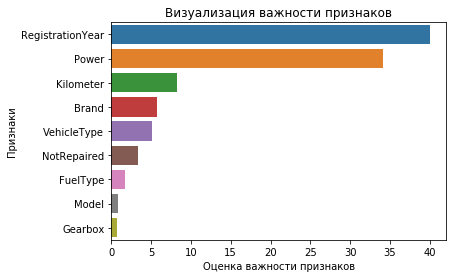

In [59]:
def chart_feature_imp(model):
    feature_imp = pd.Series(model.feature_importances_, index=features_test.columns).sort_values(ascending=False)

    ax = sns.barplot(x=feature_imp, y=feature_imp.index)
    _ = ax.set(xlabel='Оценка важности признаков', ylabel='Признаки')
    _ = ax.set_title('Визуализация важности признаков')

chart_feature_imp(catb_model)

#### Применяя метод указания категориальных столбцов

In [60]:
def to_catboost_par(features_cf, target_cf):
    model = CatBoostRegressor()
    params = {
            'n_estimators' : [15, 45],
            'verbose' : [0],
            'max_depth' : [5, 10]
    }
    grid_cv = GridSearchCV(estimator=model, param_grid=params, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
    grid_cv.fit(features_cf, target_cf, cat_features = categorical_features, verbose=30)
    print('Best hyperparams: ', grid_cv.best_params_)
    print('RMSE score on train sample: {:.2f}'.format((-grid_cv.best_score_) ** 0.5))
    return grid_cv.best_params_

In [61]:
%%time
catb_params = to_catboost_par(features_cf, target_cf)

0:	learn: 4655.0614721	total: 142ms	remaining: 1.99s
14:	learn: 3656.0371045	total: 2.82s	remaining: 0us
0:	learn: 4630.3809787	total: 181ms	remaining: 2.54s
14:	learn: 3632.0193800	total: 2.89s	remaining: 0us
0:	learn: 4636.4869512	total: 148ms	remaining: 2.07s
14:	learn: 3632.8266737	total: 2.94s	remaining: 0us
0:	learn: 4655.0614721	total: 144ms	remaining: 6.35s
30:	learn: 2999.5840981	total: 6.02s	remaining: 2.72s
44:	learn: 2652.2878164	total: 8.71s	remaining: 0us
0:	learn: 4630.3809787	total: 122ms	remaining: 5.37s
30:	learn: 2978.7135660	total: 5.99s	remaining: 2.71s
44:	learn: 2630.1089028	total: 8.59s	remaining: 0us
0:	learn: 4636.4869512	total: 141ms	remaining: 6.2s
30:	learn: 2974.4024903	total: 5.94s	remaining: 2.68s
44:	learn: 2634.5717421	total: 8.6s	remaining: 0us
0:	learn: 4643.3482295	total: 272ms	remaining: 3.81s
14:	learn: 3533.2328932	total: 4.86s	remaining: 0us
0:	learn: 4618.9565901	total: 314ms	remaining: 4.39s
14:	learn: 3510.2385138	total: 4.71s	remaining: 0us


In [62]:
%%time
catb_model = CatBoostRegressor(**catb_params)
catb_model.fit(features_train_cf, target_train_cf, cat_features = categorical_features, verbose=20)

0:	learn: 4621.2017981	total: 384ms	remaining: 16.9s
20:	learn: 3190.7557866	total: 7.48s	remaining: 8.55s
40:	learn: 2496.1010768	total: 14.6s	remaining: 1.42s
44:	learn: 2403.8728502	total: 15.9s	remaining: 0us
CPU times: user 14.8 s, sys: 1.94 s, total: 16.8 s
Wall time: 17.9 s


In [63]:
%%time
catb_pred = catb_model.predict(features_train_cf)
print('RMSE CatBootsRegressor: {:.2f}'.format(rmse(target_train_cf, catb_pred)))

RMSE CatBootsRegressor: 2402.22
CPU times: user 570 ms, sys: 25.7 ms, total: 596 ms
Wall time: 560 ms


### Вывод

Обучили модели и получили время затраченное на выполнение и получили значение RSME

## Анализ моделей

Сводная таблица по результатам

In [64]:
models = [['LR_ohe', 24.4, 0.6, 2637.22],['LR_ordinalencoder', 0.01, 0.02, 3030.01], ['LGB_ohe', 16.4, 1.42, 1712.04], 
          ['LGB_ordinalencoder', 20.5, 1, 1715.47], ['CBR_cat_features', 17.7, 0.6, 2402.22], ['CBR_ordinalencoder', 11, 0.05, 2423.2]] 
    
data = pd.DataFrame(models, columns =['Модель', 'Время обучения, сек', 'Скорость предсказания, сек', 'RMSE']) 
data 

,Модель,"Время обучения, сек","Скорость предсказания, сек",RMSE
0,LR_ohe,24.40,0.60,2637.22
1,LR_ordinalencoder,0.01,0.02,3030.01
2,LGB_ohe,16.40,1.42,1712.04
3,LGB_ordinalencoder,20.50,1.00,1715.47
4,CBR_cat_features,17.70,0.60,2402.22
5,CBR_ordinalencoder,11.00,0.05,2423.20


Учитывая только RSME, то лучше LGB, но она обучается до 2 раз дольше.
Линейная регрессия имеет RSME хуже всех, остальные значения средние.

Учитывая все значения выберем LGB_ohe, значение RMSE у нее лучше, чем у CatBoostRegressor на 30%.

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей